In [8]:
# Import Necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import datetime as dt
import array
from scipy.stats import norm
from scipy.optimize import brentq,fsolve
from scipy import interpolate
from scipy.optimize import least_squares


# Black-Scholes Model&Bachelier Model

In [9]:
# Black-Scholes Model
def BlackScholesCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def BlackScholesPut(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

# Bachelier Model
def BachelierCall(S, K, r, sigma, T):
    d = (S-K) / (S*sigma*np.sqrt(T))
    disc = np.exp(-r*T)
    return disc*((S-K)*norm.cdf(d)+S*sigma*np.sqrt(T)*norm.pdf(d))

def BachelierPut(S, K, r, sigma, T):
    d = (S-K) / (S*sigma*np.sqrt(T))
    disc = np.exp(-r*T)
    return disc*((K-S)*norm.cdf(-d)+S*sigma*np.sqrt(T)*norm.pdf(-d))

In [10]:
# Discount Rate
rate_df = pd.read_csv('zero_rates_20201201.csv')

# SPX General Data
spx_df = pd.read_csv('SPX_options.csv')
spx_df['strike_price'] = spx_df['strike_price']/1000
spx_df['mid_price'] = (spx_df['best_bid'] + spx_df['best_offer'])/2

# SPX Maturity Data
spx1 = spx_df[(spx_df.exdate == 20201218)]
spx2 = spx_df[(spx_df.exdate == 20210115)]
spx3 = spx_df[(spx_df.exdate == 20210219)]

# Time To Maturity
today = dt.date(2020, 12, 1)
exdate1 = dt.date(2020, 12, 18)
exdate2 = dt.date(2021, 1, 15)
exdate3 = dt.date(2021, 2, 19)
T1 = (exdate1-today).days/365.0
T2 = (exdate2-today).days/365.0
T3 = (exdate3-today).days/365.0

# Discount Rate Interpolation
x = rate_df['days']
y = rate_df['rate']
f = interpolate.interp1d(x,y)
r1 = f(T1*365)/100
r2 = f(T2*365)/100
r3 = f(T3*365)/100

# Underlying Value & ATM Strike Price
S = 3662.45
K = 3660

# Beta Parameter (Displaced-Diffusion Model)
beta1 = 0.8
beta2 = 0.6
beta3 = 0.4
beta4 = 0.2

# Steps Parameter (American Options)
steps = 20

In [11]:
# Implied European Options Volatility Model
def impliedCallVolatility(S, K, r, price, T):
    try:
        impliedVol = brentq(lambda x: price -
                        BlackScholesCall(S, K, r, x, T),
                        1e-6, 10)
    except Exception:
        impliedVol = np.nan
    return impliedVol

def impliedPutVolatility(S, K, r, price, T):
    try:
        impliedVol = brentq(lambda x: price -
                        BlackScholesPut(S, K, r, x, T),
                        1e-6, 10)
    except Exception:
        impliedVol = np.nan
    return impliedVol

def impliedVolatility(S, K, r, price, T, option_type):
    try:
        if option_type == 'C':
            return brentq(lambda x: price - BlackScholesCall(S, K, r, x, T), 1e-12, 10)
        else:
            return brentq(lambda x: price - BlackScholesPut(S, K, r, x, T), 1e-12, 10)
    except Exception:
        return np.nan

def calculate_atm_volatility(spx_data, S, K, r, T):
    atm_call = spx_data[(spx_data['strike_price'] == K) & (spx_data['cp_flag'] == 'C')]
    atm_put = spx_data[(spx_data['strike_price'] == K) & (spx_data['cp_flag'] == 'P')]

    if not atm_call.empty and not atm_put.empty:
        sigma_call = impliedVolatility(S, K, r, atm_call.iloc[0]['mid_price'], T, 'C')
        sigma_put = impliedVolatility(S, K, r, atm_put.iloc[0]['mid_price'], T, 'P')
        return (sigma_call + sigma_put) / 2
    else:
        return np.nan

# calculate_atm_volatility
sigma1 = calculate_atm_volatility(spx1, S, K, r1, T1)
sigma2 = calculate_atm_volatility(spx2, S, K, r2, T2)
sigma3 = calculate_atm_volatility(spx3, S, K, r3, T3)

In [12]:
sigma=[sigma1 ,sigma2 ,sigma3 ]
sigma

[0.1750985704585497, 0.18537188428716733, 0.1909732726819407]

In [13]:
# Displaced-Diffusion Model
def DisplacedDiffusionCall(S, K, r, sigma, T, beta):
    F = np.exp(r*T)*S
    c1 = (np.log(F/(F+beta*(K-F)))+(beta*sigma)**2/2*T) / (beta*sigma*np.sqrt(T))
    c2 = c1 - beta*sigma*np.sqrt(T)
    return np.exp(-r*T)*(F/beta*norm.cdf(c1) - ((1-beta)/beta*F + K)*norm.cdf(c2))

def DisplacedDiffusionPut(S, K, r, sigma, T, beta):
    F = np.exp(r*T)*S
    c1 = (np.log(F/(F+beta*(K-F)))+(beta*sigma)**2/2*T) / (beta*sigma*np.sqrt(T))
    c2 = c1 - beta*sigma*np.sqrt(T)
    return np.exp(-r*T)*(((1-beta)/beta*F + K)*norm.cdf(-c2) - F/beta*norm.cdf(-c1))

In [100]:
# #then we want to use this impliedvol to calibrate dd model's beta
# def dd_calibration(x, strikes, vols, S, r, T, sigma, payoffs):
#     err = 0.0
#     for i, vol in enumerate(vols):
#         price = dd_cal_price(r, T, S, strikes.iloc[i], x[0], sigma, payoffs.iloc[i])
#         err += (vol - impliedVolatility(S, strikes.iloc[i], r, price, T, payoffs.iloc[i]))**2
#     return err

In [101]:
# def DD_beta(mrkt_vol_smile, r, T):
#     #now we want to find strike closest to S = 3662.45 and its impliedvol
#     index = (mrkt_vol_smile["strike"] - S).abs().idxmin()
#     impliedvol = mrkt_vol_smile.iloc[index]["impliedvol"]

#     initialGuess = [0.7]
#     res = (
#         least_squares(
#             lambda x: 
#             dd_calibration(
#                 x,
#                 mrkt_vol_smile["strike"],
#                 mrkt_vol_smile["impliedvol"],
#                 S,
#                 r,
#                 T,
#                 impliedvol,
#                 mrkt_vol_smile["payoff"]),
#             initialGuess,
#             bounds=(0,1)
#         )
#     )

#     beta = res.x[0]
#     return beta

E:\software\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
E:\software\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
E:\software\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
E:\software\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_conte

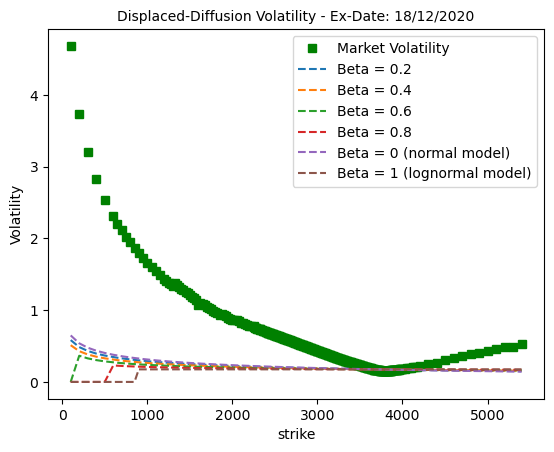

In [14]:
# Displaced Diffusion Volatility (exdate1)

spx_call1 = spx1[(spx1.cp_flag == "C")].reset_index(drop=True)
spx_put1 = spx1[(spx1.cp_flag == "P")].reset_index(drop=True)
strike1 = spx_put1["strike_price"].values

summary1 = []
for i in range(len(spx_put1.index)):
    K = strike1[i]
    if K <= S:
        impliedvol_market = impliedPutVolatility(S, K, r1, spx_put1['mid_price'][i], T1)

        price_lognormal = BlackScholesPut(S, K, r1, sigma1, T1)
        impliedvol_lognormal = impliedPutVolatility(S, K, r1, price_lognormal, T1)

        price_normal = BachelierPut(S, K, r1, sigma1, T1)
        impliedvol_normal = impliedPutVolatility(S, K, r1, price_normal, T1)
    
        price_dd1 = DisplacedDiffusionPut(S, K, r1, sigma1, T1, beta1)
        impliedvol_dd1 = impliedPutVolatility(S, K, r1, price_dd1, T1)
        
        price_dd2 = DisplacedDiffusionPut(S, K, r1, sigma1, T1, beta2)
        impliedvol_dd2 = impliedPutVolatility(S, K, r1, price_dd2, T1)
        
        price_dd3 = DisplacedDiffusionPut(S, K, r1, sigma1, T1, beta3)
        impliedvol_dd3 = impliedPutVolatility(S, K, r1, price_dd3, T1)
        
        price_dd4 = DisplacedDiffusionPut(S, K, r1, sigma1, T1, beta4)
        impliedvol_dd4 = impliedPutVolatility(S, K, r1, price_dd4, T1)

    elif K > S:
        impliedvol_market = impliedCallVolatility(S, K, r1, spx_call1['mid_price'][i], T1)

        price_lognormal = BlackScholesCall(S, K, r1, sigma1, T1)
        impliedvol_lognormal = impliedCallVolatility(S, K, r1, price_lognormal, T1)

        price_normal = BachelierCall(S, K, r1, sigma1, T1)
        impliedvol_normal = impliedCallVolatility(S, K, r1, price_normal, T1)
       
        price_dd1 = DisplacedDiffusionCall(S, K, r1, sigma1, T1, beta1)
        impliedvol_dd1 = impliedCallVolatility(S, K, r1, price_dd1, T1)
        
        price_dd2 = DisplacedDiffusionCall(S, K, r1, sigma1, T1, beta2)
        impliedvol_dd2 = impliedCallVolatility(S, K, r1, price_dd2, T1)
        
        price_dd3 = DisplacedDiffusionCall(S, K, r1, sigma1, T1, beta3)
        impliedvol_dd3 = impliedCallVolatility(S, K, r1, price_dd3, T1)
        
        price_dd4 = DisplacedDiffusionCall(S, K, r1, sigma1, T1, beta4)
        impliedvol_dd4 = impliedCallVolatility(S, K, r1, price_dd4, T1)
        
    summary1.append([K, 
                    impliedvol_market, 
                    impliedvol_lognormal,
                    impliedvol_normal, 
                    impliedvol_dd1,
                    impliedvol_dd2,
                    impliedvol_dd3,
                    impliedvol_dd4,
                    ])
    
dd_1 = pd.DataFrame(summary1, columns=['strike', 
                                        'impliedvol_market',
                                        'impliedvol_lognormal', 
                                        'impliedvol_normal', 
                                        'impliedvol_dd1',
                                        'impliedvol_dd2',
                                        'impliedvol_dd3',
                                        'impliedvol_dd4'
                                        ])
plt.plot(dd_1['strike'], dd_1['impliedvol_market'], 'gs', label = 'Market Volatility')
sns.lineplot(x = dd_1['strike'], y = dd_1['impliedvol_dd4'], label = 'Beta = 0.2', linestyle = '--')
sns.lineplot(x = dd_1['strike'], y = dd_1['impliedvol_dd3'], label = 'Beta = 0.4', linestyle = '--')
sns.lineplot(x = dd_1['strike'], y = dd_1['impliedvol_dd2'], label = 'Beta = 0.6', linestyle = '--')
sns.lineplot(x = dd_1['strike'], y = dd_1['impliedvol_dd1'], label = 'Beta = 0.8', linestyle = '--')
sns.lineplot(x = dd_1['strike'], y = dd_1['impliedvol_normal'], label = 'Beta = 0 (normal model)', linestyle = '--')
sns.lineplot(x = dd_1['strike'], y = dd_1['impliedvol_lognormal'], label = 'Beta = 1 (lognormal model)', linestyle = '--')

plt.legend()
plt.title('Displaced-Diffusion Volatility - Ex-Date: 18/12/2020', 
          fontsize = 10)
plt.ylabel('Volatility')
plt.show()

E:\software\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
E:\software\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
E:\software\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
E:\software\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_conte

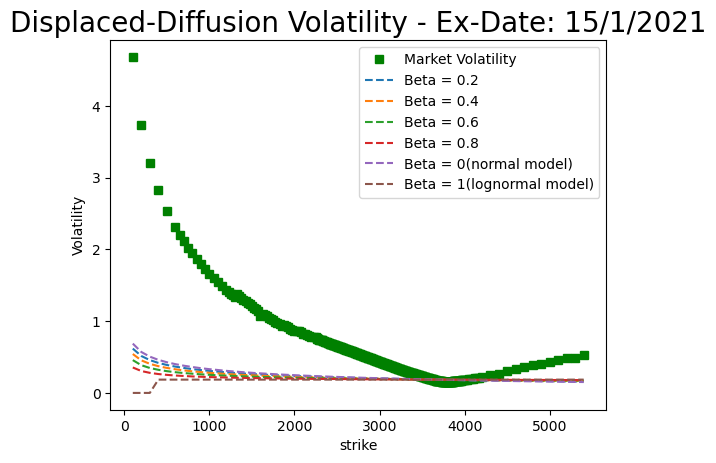

In [16]:
# Displaced Diffusion Volatility (exdate2)
spx_call2 = spx2[(spx2.cp_flag == "C")].reset_index(drop=True)
spx_put2 = spx2[(spx2.cp_flag == "P")].reset_index(drop=True)
strike2 = spx_put2["strike_price"].values

summary2 = []
for i in range(len(spx_put2.index)):
    K = strike2[i]
    if K <= S:
        impliedvol_market = impliedPutVolatility(S, K, r2, spx_put2['mid_price'][i], T2)

        price_lognormal = BlackScholesPut(S, K, r2, sigma2, T2)
        impliedvol_lognormal = impliedPutVolatility(S, K, r2, price_lognormal, T2)

        price_normal = BachelierPut(S, K, r2, sigma2, T2)
        impliedvol_normal = impliedPutVolatility(S, K, r2, price_normal, T2)
    
        price_dd1 = DisplacedDiffusionPut(S, K, r2, sigma2, T2, beta1)
        impliedvol_dd1 = impliedPutVolatility(S, K, r2, price_dd1, T2)
        
        price_dd2 = DisplacedDiffusionPut(S, K, r2, sigma2, T2, beta2)
        impliedvol_dd2 = impliedPutVolatility(S, K, r2, price_dd2, T2)
        
        price_dd3 = DisplacedDiffusionPut(S, K, r2, sigma2, T2, beta3)
        impliedvol_dd3 = impliedPutVolatility(S, K, r2, price_dd3, T2)
        
        price_dd4 = DisplacedDiffusionPut(S, K, r2, sigma2, T2, beta4)
        impliedvol_dd4 = impliedPutVolatility(S, K, r2, price_dd4, T2)

    elif K > S:
        impliedvol_market = impliedCallVolatility(S, K, r2, spx_call2['mid_price'][i], T2)

        price_lognormal = BlackScholesCall(S, K, r2, sigma2, T2)
        impliedvol_lognormal = impliedCallVolatility(S, K, r2, price_lognormal, T2)

        price_normal = BachelierCall(S, K, r2, sigma2, T2)
        impliedvol_normal = impliedCallVolatility(S, K, r2, price_normal, T2)
       
        price_dd1 = DisplacedDiffusionCall(S, K, r2, sigma2, T2, beta1)
        impliedvol_dd1 = impliedCallVolatility(S, K, r2, price_dd1, T2)
        
        price_dd2 = DisplacedDiffusionCall(S, K, r2, sigma2, T2, beta2)
        impliedvol_dd2 = impliedCallVolatility(S, K, r2, price_dd2, T2)
        
        price_dd3 = DisplacedDiffusionCall(S, K, r2, sigma2, T2, beta3)
        impliedvol_dd3 = impliedCallVolatility(S, K, r2, price_dd3, T2)
        
        price_dd4 = DisplacedDiffusionCall(S, K, r2, sigma2, T2, beta4)
        impliedvol_dd4 = impliedCallVolatility(S, K, r2, price_dd4, T2)
        
    summary2.append([K, 
                     impliedvol_market, 
                     impliedvol_lognormal,
                     impliedvol_normal, 
                     impliedvol_dd1,
                     impliedvol_dd2,
                     impliedvol_dd3,
                     impliedvol_dd4,])
    
dd_2 = pd.DataFrame(summary2, columns=['strike', 
                                       'impliedvol_market',
                                       'impliedvol_lognormal', 
                                       'impliedvol_normal', 
                                       'impliedvol_dd1',
                                       'impliedvol_dd2',
                                       'impliedvol_dd3',
                                       'impliedvol_dd4'])
plt.plot(dd_1['strike'], dd_1['impliedvol_market'], 'gs', label = 'Market Volatility')
sns.lineplot(x = dd_2['strike'], y = dd_2['impliedvol_dd4'], label = 'Beta = 0.2', linestyle = '--')
sns.lineplot(x = dd_2['strike'], y = dd_2['impliedvol_dd3'], label = 'Beta = 0.4', linestyle = '--')
sns.lineplot(x = dd_2['strike'], y = dd_2['impliedvol_dd2'], label = 'Beta = 0.6', linestyle = '--')
sns.lineplot(x = dd_2['strike'], y = dd_2['impliedvol_dd1'], label = 'Beta = 0.8', linestyle = '--')
sns.lineplot(x = dd_2['strike'], y = dd_2['impliedvol_normal'], label = 'Beta = 0(normal model)', linestyle = '--')
sns.lineplot(x = dd_2['strike'], y = dd_2['impliedvol_lognormal'], label = 'Beta = 1(lognormal model)', linestyle = '--')

plt.legend()
plt.title('Displaced-Diffusion Volatility - Ex-Date: 15/1/2021', 
          fontsize = 20)
plt.ylabel('Volatility')
plt.show()

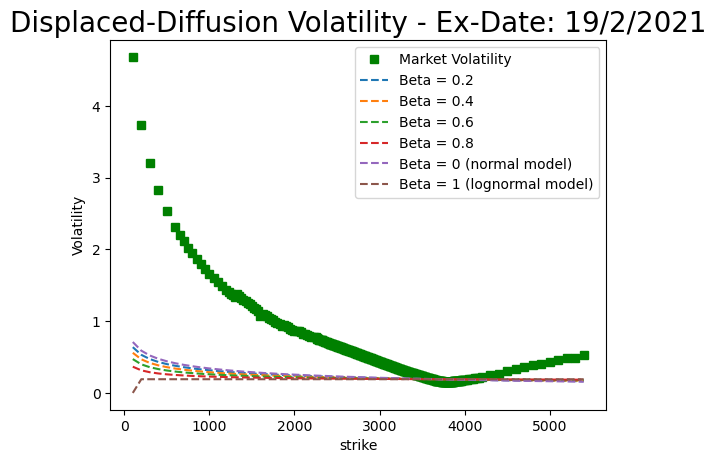

In [104]:
# Displaced Diffusion Volatility (exdate3)
spx_call3 = spx3[(spx3.cp_flag == "C")].reset_index(drop=True)
spx_put3 = spx3[(spx3.cp_flag == "P")].reset_index(drop=True)
strike3 = spx_put3["strike_price"].values

summary3 = []
for i in range(len(spx_put3.index)):
    K = strike3[i]
    if K <= S:
        impliedvol_market = impliedPutVolatility(S, K, r3, spx_put3['mid_price'][i], T3)

        price_lognormal = BlackScholesPut(S, K, r3, sigma3, T3)
        impliedvol_lognormal = impliedPutVolatility(S, K, r3, price_lognormal, T3)

        price_normal = BachelierPut(S, K, r3, sigma3, T3)
        impliedvol_normal = impliedPutVolatility(S, K, r3, price_normal, T3)
    
        price_dd1 = DisplacedDiffusionPut(S, K, r3, sigma3, T3, beta1)
        impliedvol_dd1 = impliedPutVolatility(S, K, r3, price_dd1, T3)
        
        price_dd2 = DisplacedDiffusionPut(S, K, r3, sigma3, T3, beta2)
        impliedvol_dd2 = impliedPutVolatility(S, K, r3, price_dd2, T3)
        
        price_dd3 = DisplacedDiffusionPut(S, K, r3, sigma3, T3, beta3)
        impliedvol_dd3 = impliedPutVolatility(S, K, r3, price_dd3, T3)
        
        price_dd4 = DisplacedDiffusionPut(S, K, r3, sigma3, T3, beta4)
        impliedvol_dd4 = impliedPutVolatility(S, K, r3, price_dd4, T3)

    elif K > S:
        impliedvol_market = impliedCallVolatility(S, K, r3, spx_call3['mid_price'][i], T3)

        price_lognormal = BlackScholesCall(S, K, r3, sigma3, T3)
        impliedvol_lognormal = impliedCallVolatility(S, K, r3, price_lognormal, T3)

        price_normal = BachelierCall(S, K, r3, sigma3, T3)
        impliedvol_normal = impliedCallVolatility(S, K, r3, price_normal, T3)
       
        price_dd1 = DisplacedDiffusionCall(S, K, r3, sigma3, T3, beta1)
        impliedvol_dd1 = impliedCallVolatility(S, K, r3, price_dd1, T3)
        
        price_dd2 = DisplacedDiffusionCall(S, K, r3, sigma3, T3, beta2)
        impliedvol_dd2 = impliedCallVolatility(S, K, r3, price_dd2, T3)
        
        price_dd3 = DisplacedDiffusionCall(S, K, r3, sigma3, T3, beta3)
        impliedvol_dd3 = impliedCallVolatility(S, K, r3, price_dd3, T3)
        
        price_dd4 = DisplacedDiffusionCall(S, K, r3, sigma3, T3, beta4)
        impliedvol_dd4 = impliedCallVolatility(S, K, r3, price_dd4, T3)
        
    summary3.append([K, 
                     impliedvol_market, 
                     impliedvol_lognormal,
                     impliedvol_normal, 
                     impliedvol_dd1,
                     impliedvol_dd2,
                     impliedvol_dd3,
                     impliedvol_dd4,])
    
dd_3 = pd.DataFrame(summary3, columns=['strike', 
                                       'impliedvol_market',
                                       'impliedvol_lognormal', 
                                       'impliedvol_normal', 
                                       'impliedvol_dd1',
                                       'impliedvol_dd2',
                                       'impliedvol_dd3',
                                       'impliedvol_dd4'])
plt.plot(dd_1['strike'], dd_1['impliedvol_market'], 'gs', label = 'Market Volatility')
sns.lineplot(x = dd_3['strike'], y = dd_3['impliedvol_dd4'], label = 'Beta = 0.2', linestyle = '--')
sns.lineplot(x = dd_3['strike'], y = dd_3['impliedvol_dd3'], label = 'Beta = 0.4', linestyle = '--')
sns.lineplot(x = dd_3['strike'], y = dd_3['impliedvol_dd2'], label = 'Beta = 0.6', linestyle = '--')
sns.lineplot(x = dd_3['strike'], y = dd_3['impliedvol_dd1'], label = 'Beta = 0.8', linestyle = '--')
sns.lineplot(x = dd_3['strike'], y = dd_3['impliedvol_normal'], label = 'Beta = 0 (normal model)', linestyle = '--')
sns.lineplot(x = dd_3['strike'], y = dd_3['impliedvol_lognormal'], label = 'Beta = 1 (lognormal model)', linestyle = '--')

plt.legend()
plt.title('Displaced-Diffusion Volatility - Ex-Date: 19/2/2021', 
          fontsize = 20)
plt.ylabel('Volatility')
plt.show()

# SABR MODEL

In [17]:
# SPY General Data
spy_df = pd.read_csv('SPY_options.csv')
spy_df['strike_price'] = spy_df['strike_price']/1000
spy_df['mid_price'] = (spy_df['best_bid'] + spy_df['best_offer'])/2
S_A = 366.02

# SPY Maturity Data
spy1 = spy_df[(spy_df.exdate == 20201218)]
spy2 = spy_df[(spy_df.exdate == 20210115)]
spy3 = spy_df[(spy_df.exdate == 20210219)]

def american_put(S, K, r, sigma, T, steps):
    R = (1+r)**(T/steps)
    u = np.exp(sigma*np.sqrt(T/steps))
    uu = u*u
    d = 1.0/u
    p_up = (R-d)/(u-d)
    p_down = 1.0-p_up
    prices = array.array('d', (0 for i in range(0, steps+1)))
    prices[0] = S*pow(d, steps)

    for i in range(1, steps+1):
        prices[i] = uu*prices[i-1]

    put_values = array.array('d', (0 for i in range(0, steps+1)))

    for i in range(0, steps+1):
        put_values[i] = max(0.0, (K-prices[i]))

    for step in range(steps-1, -1, -1):
        for i in range(0, step+1):
            put_values[i] = (p_up*put_values[i+1]+p_down*put_values[i])/R
            prices[i] = d*prices[i+1]
            put_values[i] = max(put_values[i], (K-prices[i]))
    return put_values[0]

def european_put(S, K, r, sigma, T, steps):
    R = (1+r)**(T/steps)
    u = np.exp(sigma*np.sqrt(T/steps))
    uu = u*u
    d = 1.0/u
    p_up = (R-d)/(u-d)
    p_down = 1.0-p_up
    prices = array.array('d', (0 for i in range(0, steps+1)))
    prices[0] = S*pow(d, steps)

    for i in range(1, steps+1):
        prices[i] = uu*prices[i-1]

    put_values = array.array('d', (0 for i in range(0, steps+1)))

    for i in range(0, steps+1):
        put_values[i] = max(0.0, (K-prices[i]))

    for step in range(steps-1, -1, -1):
        for i in range(0, step+1):
            put_values[i] = (p_up*put_values[i+1]+p_down*put_values[i])/R
            prices[i] = d*prices[i+1]
    return put_values[0]

def american_call(S, K, r, sigma, T, steps):
    R = (1+r)**(T/steps)
    u = np.exp(sigma*np.sqrt(T/steps))
    d = 1.0/u
    p_up = (R-d)/(u-d)
    p_down = 1.0-p_up

    prices = array.array('d', (0 for i in range(0, steps+1)))

    prices[0] = S*pow(d, steps)
    uu = u*u
    for i in range(1, steps+1):
        prices[i] = uu*prices[i-1]

    call_values = array.array('d', (0 for i in range(0, steps+1)))
    for i in range(0, steps+1):
        call_values[i] = max(0.0, (prices[i]-K))

    for step in range(steps-1, -1, -1):
        for i in range(0, step+1):
            call_values[i] = (p_up*call_values[i+1]+p_down*call_values[i])/R
            prices[i] = d*prices[i+1]
            call_values[i] = max(call_values[i], 1.0*(prices[i]-K))

    return call_values[0]

def european_call(S, K, r, sigma, T, steps):
    R = (1+r)**(T/steps)
    u = np.exp(sigma*np.sqrt(T/steps))
    d = 1.0/u
    p_up = (R-d)/(u-d)
    p_down = 1.0-p_up

    # price of underlying
    prices = array.array('d', (0 for i in range(0, steps+1)))

    # fill in the endnodes
    prices[0] = S*pow(d, steps)
    uu = u*u
    for i in range(1, steps+1):
        prices[i] = uu*prices[i-1]

    call_values = array.array('d', (0 for i in range(0, steps+1)))
    for i in range(0, steps+1):
        call_values[i] = max(0.0, (prices[i]-K))

    for step in range(steps-1, -1, -1):
        for i in range(0, step+1):
            call_values[i] = (p_up*call_values[i+1]+p_down*call_values[i])/R
            prices[i] = d*prices[i+1]

    return call_values[0]

In [18]:
K2=366

In [19]:
sigma_1 = calculate_atm_volatility(spy1, S_A, K2, r1, T1)
sigma_2 = calculate_atm_volatility(spy2, S_A, K2, r2, T2)
sigma_3 = calculate_atm_volatility(spy3, S_A, K2, r3, T3)
sigma_y=[sigma_1,sigma_2,sigma_3]
sigma_y

[0.186690316986162, 0.18481154419544626, 0.19108134783087416]

In [20]:
def process_american_options(spy, S_A, r, sigma, T, steps):
    spy_call = spy[(spy.cp_flag == "C")].reset_index(drop=True)
    spy_put = spy[(spy.cp_flag == "P")].reset_index(drop=True)
    strikes = spy_put["strike_price"].values

    summary_T = []
    for i, K in enumerate(strikes):
        if K <= S_A:
            AP = american_put(S_A, K, r, sigma, T, steps)
            EP = european_put(S_A, K, r, sigma, T, steps)
        else:
            AP = american_call(S_A, K, r, sigma, T, steps)
            EP = european_call(S_A, K, r, sigma, T, steps)
        
        summary_T.append([K, AP, EP])

    T_df = pd.DataFrame(summary_T, columns=['strike', 'AP', 'EP'])
    T_df['Premium'] = T_df['AP'] - T_df["EP"]

    spy_put['mid_price_stripped'] = spy_put['mid_price'] - T_df['Premium']
    spy_call['mid_price_stripped'] = spy_call['mid_price'] - T_df['Premium']

    summary = []
    for i, K in enumerate(strikes):
        if K <= S_A:
            impliedvol_market = impliedPutVolatility(S_A, K, r, spy_put['mid_price_stripped'][i], T)
        else:
            impliedvol_market = impliedCallVolatility(S_A, K, r, spy_call['mid_price_stripped'][i], T)
        
        summary.append([K, impliedvol_market])

    return pd.DataFrame(summary, columns=['strike', 'impliedvol_market'])

A1 = process_american_options(spy1, S_A, r1, sigma1, T1, steps)
A2 = process_american_options(spy2, S_A, r2, sigma2, T2, steps)
A3 = process_american_options(spy3, S_A, r3, sigma3, T3, steps)


In [21]:
# SABR Calibration
def sabrcalibration(x, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], beta, x[1], x[2]))**2
    return err

# SABR Model
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom
    return sabrsigma

beta = 0.7

C:\Users\eke\AppData\Local\Temp\ipykernel_3156\3075488719.py:21: RuntimeWarning: invalid value encountered in scalar power
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
C:\Users\eke\AppData\Local\Temp\ipykernel_3156\3075488719.py:21: RuntimeWarning: invalid value encountered in log
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))


SABR Calibration for 18/12/2020: alpha = 1.212, beta = 0.7, rho = -0.301, nu = 5.460


E:\software\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
E:\software\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
E:\software\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
E:\software\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_conte

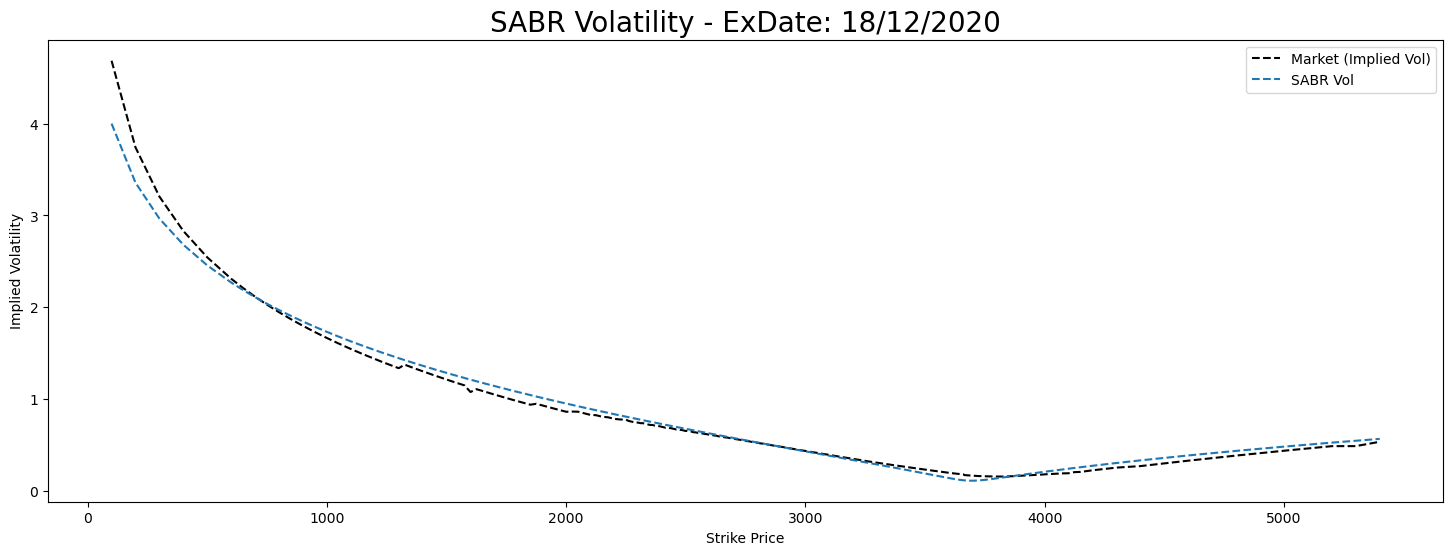

C:\Users\eke\AppData\Local\Temp\ipykernel_3156\3075488719.py:21: RuntimeWarning: invalid value encountered in scalar power
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
C:\Users\eke\AppData\Local\Temp\ipykernel_3156\3075488719.py:21: RuntimeWarning: invalid value encountered in log
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))


SABR Calibration for 15/1/2021: alpha = 1.817, beta = 0.7, rho = -0.404, nu = 2.790


E:\software\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
E:\software\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
E:\software\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
E:\software\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_conte

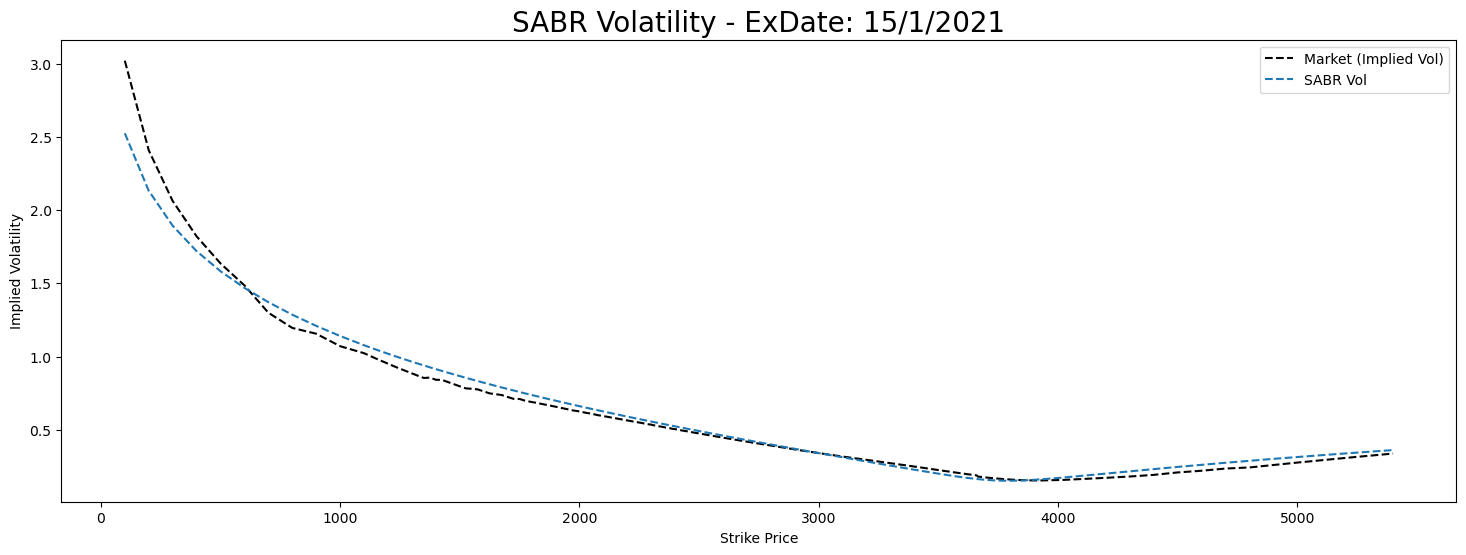

NameError: name 'dd_3' is not defined

In [22]:
def sabr_volatility_calib_plot(dd, r, T, S, beta, exdate):
    F = np.exp(r * T) * S
    initialGuess = [0.1, 0.1, 0.1]
    res = least_squares(lambda x: sabrcalibration(x, dd['strike'], dd['impliedvol_market'], F, T),
                        initialGuess)

    alpha = res.x[0]
    rho = res.x[1]
    nu = res.x[2]

    SABR_values = [SABR(F, K, T, alpha, beta, rho, nu) for K in dd['strike']]

    print(f'SABR Calibration for {exdate}: alpha = {alpha:.3f}, beta = {beta:.1f}, rho = {rho:.3f}, nu = {nu:.3f}')

    plt.figure(figsize=(18, 6))
    plt.plot(dd['strike'], dd['impliedvol_market'], 'k--', label='Market (Implied Vol)')
    sns.lineplot(x=dd['strike'], y=SABR_values, label='SABR Vol', linestyle='--')
    plt.title(f'SABR Volatility - ExDate: {exdate}', fontsize=20)
    plt.xlabel('Strike Price')
    plt.ylabel('Implied Volatility')
    plt.legend()
    plt.show()

# Example of how to use the function
# You need to define dd_1, dd_2, dd_3, r1, r2, r3, T1, T2, T3, S, and beta before calling this function
sabr_volatility_calib_plot(dd_1, r1, T1, S, beta, '18/12/2020')
sabr_volatility_calib_plot(dd_2, r2, T2, S, beta, '15/1/2021')
sabr_volatility_calib_plot(dd_3, r3, T3, S, beta, '19/2/2021')

sabr_volatility_calib_plot(A1, r1, T1, S_A, beta, '18/12/2020')
sabr_volatility_calib_plot(A2, r2, T2, S_A, beta, '15/1/2021')
sabr_volatility_calib_plot(A3, r3, T3, S_A, beta, '19/2/2021')